In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =300

ng =4

nref =1

p_refs = (/ 50 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 4 /) 

data wgt
     &     /1 , 0.6 , 0.4 , 0.3/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /1.6 , 1.6 , 1.6 , 1.6/

klin =0

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

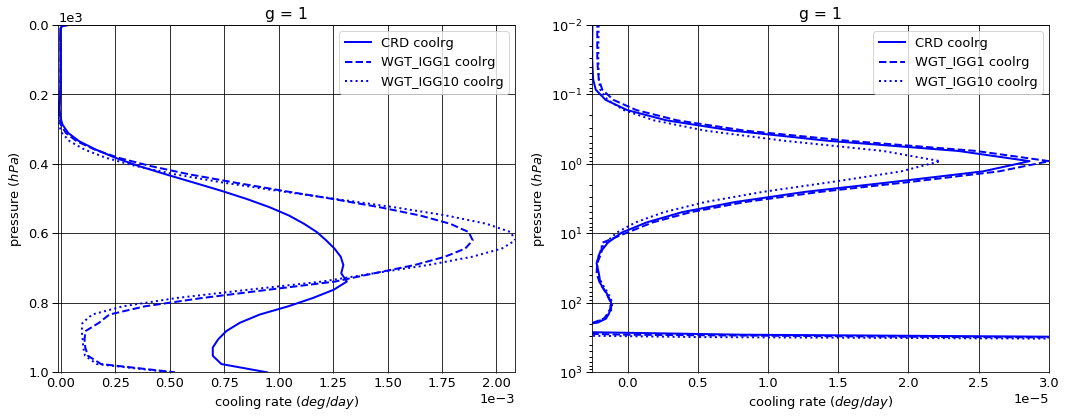

# Figure: cooling rate g-group 2

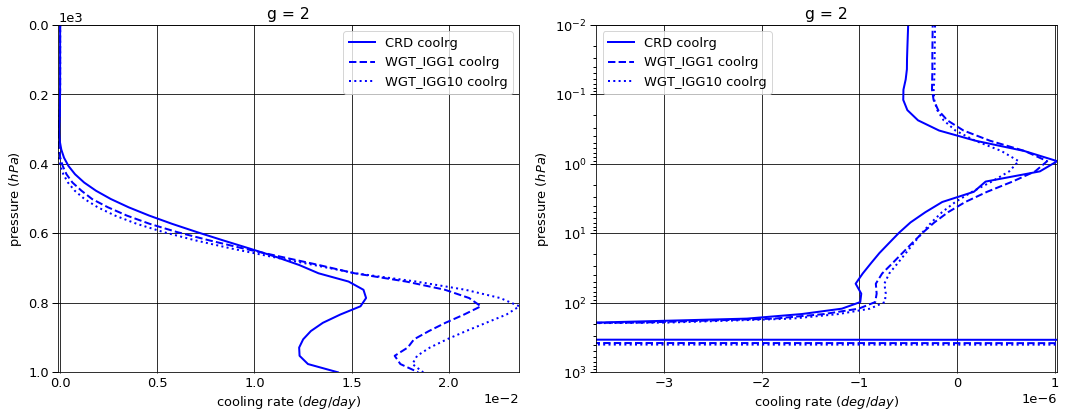

# Figure: cooling rate g-group 3

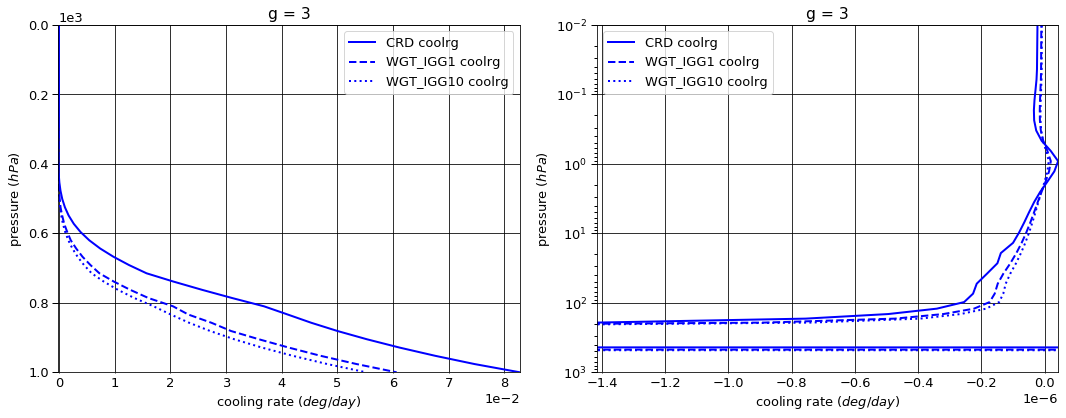

# Figure: cooling rate g-group 4

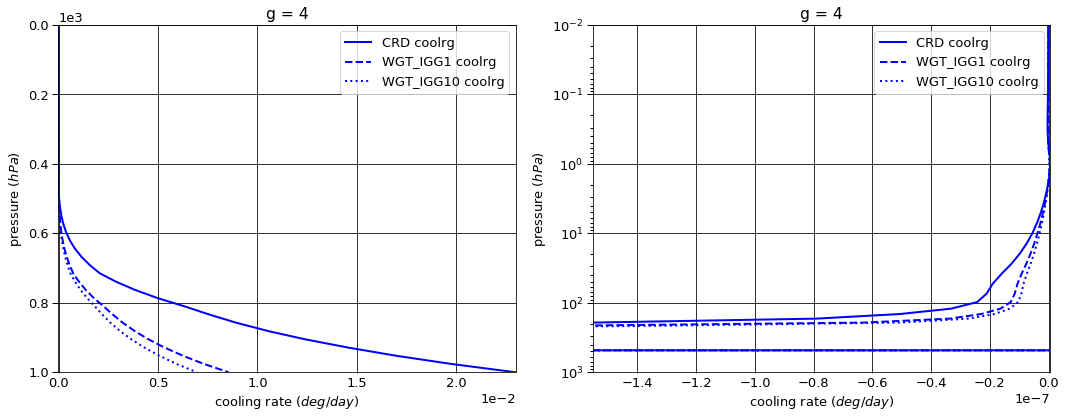

# Figure: cooling rate g-group total

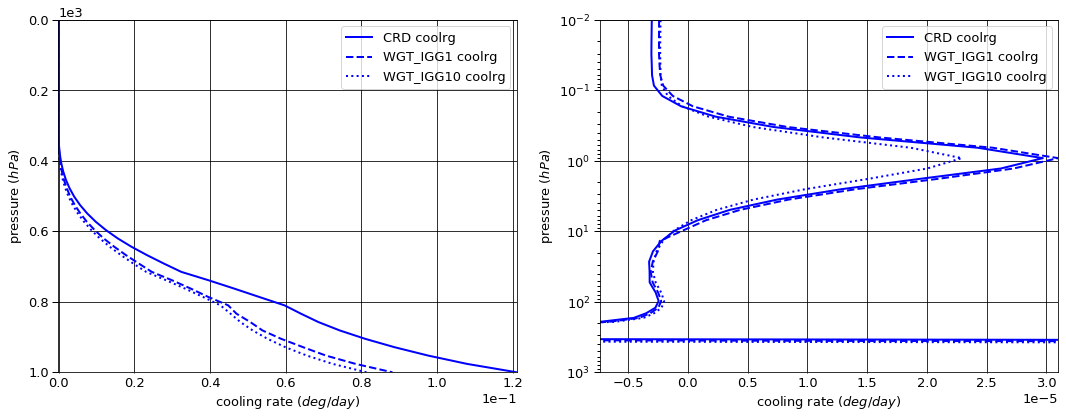

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.080895  0.000000  -0.080895
  1013.0   76     -0.127230  0.117483  -0.009747
2 0.0      1      -1.066815  0.000000  -1.066815
  1013.0   76     -1.338831  0.974280  -0.364552
3 0.0      1     -10.579067  0.000000 -10.579067
  1013.0   76    -10.953526  2.213682  -8.739844
4 0.0      1     -22.246332  0.000000 -22.246332
  1013.0   76    -22.309055  0.453076 -21.855978


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.071386  0.000000  -0.071386
  1013.0   76     -0.127230  0.125446  -0.001784
2 0.0      1      -1.053018  0.000000  -1.053018
  1013.0   76     -1.338831  1.147962  -0.190869
3 0.0      1     -10.748456  0.000000 -10.748456
  1013.0   76    -10.953526  1.344280  -9.609246
4 0.0      1     -22.286738  0.000000 -22.286738
  1013.0   76    -22.309055  0.164507 -22.144548


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.071546  0.000000  -0.071546
  1013.0   76     -0.127230  0.125612  -0.001618
2 0.0      1      -1.057150  0.000000  -1.057150
  1013.0   76     -1.338831  1.172925  -0.165906
3 0.0      1     -10.779990  0.000000 -10.779990
  1013.0   76    -10.953526  1.167927  -9.785599
4 0.0      1     -22.291052  0.000000 -22.291052
  1013.0   76    -22.309055  0.133019 -22.176035


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      9.509143e-03  0.000000  0.009509
  1013.0   76     0.000000e+00  0.007963  0.007963
2 0.0      1      1.379710e-02  0.000000  0.013797
  1013.0   76     0.000000e+00  0.173683  0.173683
3 0.0      1     -1.693890e-01  0.000000 -0.169389
  1013.0   76     0.000000e+00 -0.869402 -0.869402
4 0.0      1     -4.040600e-02  0.000000 -0.040406
  1013.0   76    -3.552714e-15 -0.288569 -0.288570


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      9.349637e-03  0.000000  0.009350
  1013.0   76     0.000000e+00  0.008129  0.008129
2 0.0      1      9.665400e-03  0.000000  0.009665
  1013.0   76     0.000000e+00  0.198645  0.198645
3 0.0      1     -2.009230e-01  0.000000 -0.200923
  1013.0   76     0.000000e+00 -1.045755 -1.045755
4 0.0      1     -4.472000e-02  0.000000 -0.044720
  1013.0   76    -3.552714e-15 -0.320057 -0.320057

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.364486e-06
  1001.112500 75     9.467736e-04
2 0.000312    1     -4.660154e-07
  1001.112500 75     1.429325e-02
3 0.000312    1     -1.983747e-08
  1001.112500 75     8.280763e-02
4 0.000312    1     -9.606521e-11
  1001.112500 75     2.301446e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -2.063576e-06
  1001.112500 75     5.243942e-04
2 0.000312    1     -2.358761e-07
  1001.112500 75     1.843089e-02
3 0.000312    1     -9.102179e-09
  1001.112500 75     6.067829e-02
4 0.000312    1     -4.803261e-11
  1001.112500 75     8.556307e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.928091e-06
  1001.112500 75     5.049603e-04
2 0.000312    1     -2.111243e-07
  1001.112500 75     1.868508e-02
3 0.000312    1     -7.493087e-09
  1001.112500 75     5.519033e-02
4 0.000312    1      0.000000e+00
  1001.112500 75     6.949185e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.009106e-07
  1001.112500 75    -4.223794e-04
2 0.000312    1      2.301392e-07
  1001.112500 75     4.137636e-03
3 0.000312    1      1.073529e-08
  1001.112500 75    -2.212934e-02
4 0.000312    1      4.803261e-11
  1001.112500 75    -1.445815e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.363950e-07
  1001.112500 75    -4.418133e-04
2 0.000312    1      2.548910e-07
  1001.112500 75     4.391824e-03
3 0.000312    1      1.234438e-08
  1001.112500 75    -2.761730e-02
4 0.000312    1      9.606521e-11
  1001.112500 75    -1.606527e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.973110,0.000000,-33.973110
1013.0,76,-34.728642,3.758521,-30.970121



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.159598,0.000000,-34.159598
1013.0,76,-34.728642,2.782195,-31.946448



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.199738,0.000000,-34.199738
1013.0,76,-34.728642,2.599483,-32.129159



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.186489,0.000000,-0.186489
1013.0,76,0.000000,-0.976326,-0.976326



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.226628,0.000000,-0.226628
1013.0,76,0.000000,-1.159038,-1.159038


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.121062



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.088190



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.081330



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,5.418332e-07
1001.112500,75,-3.287223e-02



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,7.037265e-07
1001.112500,75,-3.973256e-02


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.003750,0.003620
2,0.039167,0.038239
3,0.320417,0.312903
4,0.636667,0.645238


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.458881e-23
2,4.092653e-25
3,6.811963e-27
4,1.133809e-28


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.458881e-23,NaN,0.003750,0.003620,0.003750,0.003620,50.0
2,4.092653e-25,0.016644,0.039167,0.038239,0.042917,0.041859,50.0
3,6.811963e-27,0.016644,0.320417,0.312903,0.363333,0.354762,50.0
4,1.133809e-28,0.016644,0.636667,0.645238,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.065775e-23  7.739072e-24   3.961424  2.121315e-09
      2 0.000312     3.008882e-25  2.275226e-26  13.224544  1.312142e-11
      3 0.000312     1.291352e-27  1.561470e-28   8.270107  4.222385e-14
      4 0.000312     2.384400e-30  4.397408e-31   5.422285  7.079446e-17
2     1 0.000750     3.101544e-23  7.779179e-24   3.986981  8.644063e-10
      2 0.000750     3.032947e-25  2.286627e-26  13.263846  5.326644e-12
      3 0.000750     1.305172e-27  1.571389e-28   8.305849  1.717786e-14
      4 0.000750     2.423333e-30  4.489173e-31   5.398174  2.901962e-17
3     1 0.001052     3.175163e-23  7.859918e-24   4.039690  1.241005e-09
      2 0.001052     3.082299e-25  2.308752e-26  13.350498  7.589202e-12
      3 0.001052     1.333484e-27  1.589718e-28   8.388176  2.457558e-14
      4 0.001052     2.497244e-30  4.609975e-31   5.417044  4.189384e-17
4     1 0.001476     3.251391e-23  7.941636e-24   4.094108  1.782793e-09
      2 0.001476     3.133216e-25  2.331672e-26  13.437638  1.081937e-11
      3 0.001476     1.362904e-27  1.608777e-28   8.471678  3.518485e-14
      4 0.001476     2.576087e-30  4.749734e-31   5.423646  6.060588e-17
5     1 0.002070     3.329259e-23  8.023233e-24   4.149523  2.560407e-09
      2 0.002070     3.185050e-25  2.355212e-26  13.523411  1.542153e-11
      3 0.002070     1.393086e-27  1.628513e-28   8.554345  5.036937e-14
      4 0.002070     2.659703e-30  4.914333e-31   5.412135  8.782031e-17
6     1 0.002904     3.408772e-23  8.104713e-24   4.205913  3.677357e-09
      2 0.002904     3.237809e-25  2.379542e-26  13.606854  2.198436e-11
      3 0.002904     1.424067e-27  1.649188e-28   8.634960  7.212570e-14
      4 0.002904     2.749166e-30  5.113827e-31   5.375946  1.275907e-16
7     1 0.004074     3.489950e-23  8.186122e-24   4.263252  5.281347e-09
      2 0.004074     3.291513e-25  2.404913e-26  13.686621  3.134205e-11
      3 0.004074     1.455898e-27  1.671183e-28   8.711784  1.033026e-13
      4 0.004074     2.845998e-30  5.362634e-31   5.307090  1.860126e-16
8     1 0.005714     3.572873e-23  8.267599e-24   4.321536  7.584059e-09
      2 0.005714     3.346227e-25  2.431696e-26  13.760876  4.468246e-11
      3 0.005714     1.488672e-27  1.695061e-28   8.782411  1.479873e-13
      4 0.005714     2.952408e-30  5.681447e-31   5.196577  2.724295e-16
9     1 0.008015     3.657539e-23  8.349259e-24   4.380674  1.089036e-08
      2 0.008015     3.401967e-25  2.460395e-26  13.826915  6.370672e-11
      3 0.008015     1.522471e-27  1.721603e-28   8.843334  2.120835e-13
      4 0.008015     3.071415e-30  6.099740e-31   5.035320  4.014895e-16
10    1 0.011243     3.744007e-23  8.431350e-24   4.440578  1.563699e-08
      2 0.011243     3.458799e-25  2.491746e-26  13.881025  9.083762e-11
      3 0.011243     1.557434e-27  1.751943e-28   8.889756  3.040898e-13
      4 0.011243     3.207377e-30  6.659766e-31   4.816050  5.965755e-16
11    1 0.015771     3.832331e-23  8.514217e-24   4.501097  2.245172e-08
      2 0.015771     3.516799e-25  2.526798e-26  13.918008  1.295404e-10
      3 0.015771     1.593745e-27  1.787696e-28   8.915083  4.363178e-13
      4 0.015771     3.366472e-30  7.421916e-31   4.535854  8.960438e-16
12    1 0.022122     3.922590e-23  8.598379e-24   4.562011  3.223495e-08
      2 0.022122     3.576075e-25  2.567043e-26  13.930715  1.847624e-10
      3 0.022122     1.631664e-27  1.831169e-28   8.910501  6.266344e-13
      4 0.022122     3.557522e-30  8.472529e-31   4.198890  1.364424e-15
13    1 0.031031     4.015188e-23  8.684842e-24   4.623214  4.628379e-08
      2 0.031031     3.636975e-25  2.614697e-26  13.909740  2.636004e-10
      3 0.031031     1.671671e-27  1.885718e-28   8.864907  9.012081e-13
      4 0.031031     3.793469e-30  9.935575e-31   3.818067  2.113544e-15
14    1 0.043528     4.136090e-23  8.795776e-24   4.702359  6.687749e-08
      2 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
